In [1]:
#import sys
#sys.path.insert(0,"/workspace/bt")

import yfinance as yf
import matplotlib.pyplot as plt
from strategy import *

%matplotlib inline

bt version :  (0, 2, 9)


In [2]:
# 투자자산
tickers = ['TQQQ','TMF']
# 비교자산+안전자산
dualtickers = ['BND','BIL']

# 월초 리밸런싱
run_on_end_of_period = False
# 지연시간 1일, 하루전 종가 기준으로 리밸런싱
lag = 1
resample_monthly = False


In [3]:
data = yf.download(tickers+dualtickers)['Adj Close']
data = data[tickers+dualtickers]
for c in data.columns:
    print(c, data[c].first_valid_index())
assets = data.dropna().copy()

if resample_monthly:
    assets = assets.resample('M').last().dropna()
    lag = 0
    
start_day = assets.index.min() + pd.DateOffset(months=12) - pd.DateOffset(days=1)
print('asset \n', assets)
print('start day : ', start_day)

[*********************100%***********************]  4 of 4 completed
TQQQ 2010-02-11 00:00:00
TMF 2009-04-16 00:00:00
BND 2007-04-10 00:00:00
BIL 2007-05-30 00:00:00
asset 
                  TQQQ        TMF        BND        BIL
Date                                                  
2010-02-11   0.431471   6.695424  55.449631  86.560005
2010-02-12   0.433238   6.771190  55.526699  86.560005
2010-02-16   0.450019   6.831800  55.596813  86.560005
2010-02-17   0.457656   6.613165  55.470650  86.503410
2010-02-18   0.466332   6.500601  55.393559  86.541138
...               ...        ...        ...        ...
2022-12-02  23.410000   9.610000  73.500000  91.440002
2022-12-05  22.230000   9.230000  72.919998  91.449997
2022-12-06  20.820000   9.590000  73.160004  91.480003
2022-12-07  20.570000  10.230000  73.800003  91.480003
2022-12-08  21.299999  10.160000  73.589996  91.540001

[3230 rows x 4 columns]
start day :  2011-02-10 00:00:00


In [4]:
# 매수&보유 백테스트
def long_only_ew(assets, start_day, name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

Stat                 benchmark(TQQQ)
-------------------  -----------------
Start                2011-02-10
End                  2022-12-08
Risk-free rate       0.00%

Total Return         2209.77%
Daily Sharpe         0.74
Daily Sortino        1.16
CAGR                 30.41%
Max Drawdown         -80.64%
Calmar Ratio         0.38

MTD                  -9.59%
3m                   -24.09%
6m                   -34.76%
YTD                  -74.39%
1Y                   -74.91%
3Y (ann.)            3.72%
5Y (ann.)            13.57%
10Y (ann.)           35.00%
Since Incep. (ann.)  30.41%

Daily Sharpe         0.74
Daily Sortino        1.16
Daily Mean (ann.)    46.12%
Daily Vol (ann.)     62.02%
Daily Skew           -0.40
Daily Kurt           6.39
Best Day             26.99%
Worst Day            -34.47%

Monthly Sharpe       0.77
Monthly Sortino      1.45
Monthly Mean (ann.)  41.24%
Monthly Vol (ann.)   53.28%
Monthly Skew         -0.14
Monthly Kurt         0.28
Best Month           46.45%
Wo

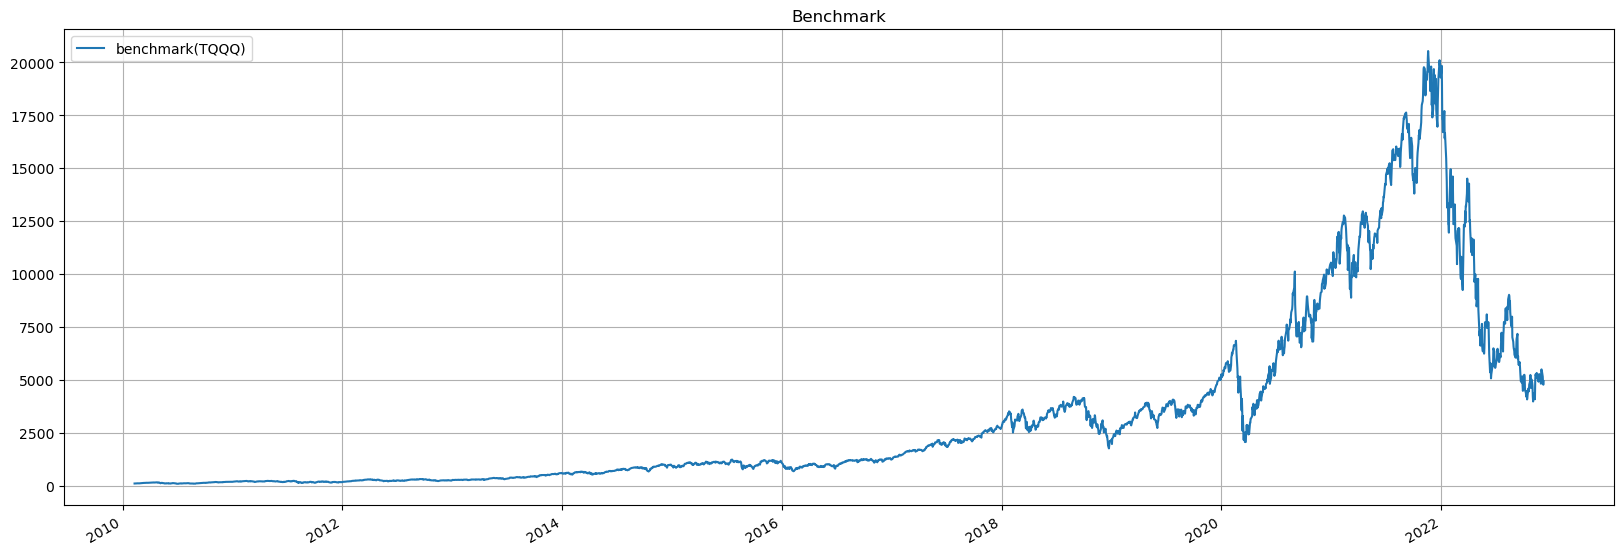

In [5]:
# 벤치마크 수익율
benchmark = long_only_ew(assets[tickers[0]].to_frame(), start_day, 'benchmark({})'.format(tickers[0]))
report = bt.run(benchmark)

report.plot(figsize=(20,7), grid=True, title="Benchmark")
print(report.prices[start_day:].calc_stats().display())

In [6]:
# 상대모멘텀 백테스트
def RelativeMomentum_BT(assets, rank, months, start_day, run_on_end_of_period=False, lag=1, name='Relative Momentum'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           SelectRelativeMomentum(rank=rank, lookback=pd.DateOffset(months=months), lag=pd.DateOffset(days=lag)),
                           bt.algos.WeighEqually(),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [7]:
# 상대모멘텀 상위 1종목 (1~12개월 비교)
relativemomentum = {}
for i in range(0, 12):
    relativemomentum[i] = RelativeMomentum_BT(assets[tickers], 1, i+1, start_day, False, lag, name='RM({})'.format(str(i+1)))
    
rm1_report = bt.run(*relativemomentum.values())

<AxesSubplot:title={'center':'Relative Momentum (1~12 month) with rank 1'}>

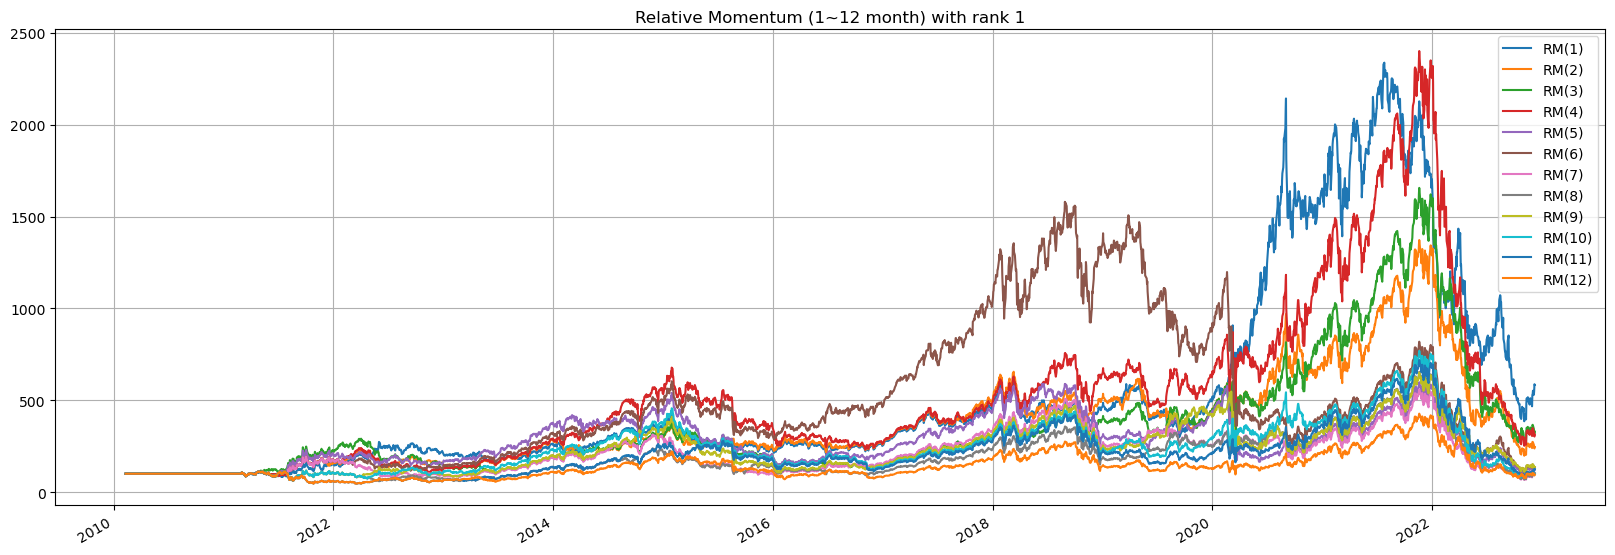

In [8]:
rm1_report.plot(figsize=(20,7), grid=True, title="Relative Momentum (1~12 month) with rank 1")

In [9]:
print(rm1_report.prices[start_day:].calc_stats().display())

Stat                 RM(1)       RM(2)       RM(3)       RM(4)       RM(5)       RM(6)       RM(7)       RM(8)       RM(9)       RM(10)      RM(11)      RM(12)
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10
End                  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         483.40%     146.05%     229.43%     213.21%     21.19%      35.39%      0.20%       4.07%       36.80%      -3.34%      25.75%      -6.09%
Daily Sharpe         0.55   

In [10]:
# 절대모멘텀 백테스트
def AbsoluteMomentum_BT(assets, rank, months, start_day, run_on_end_of_period=False, lag=1, name='Absolute Momentum'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           SelectAbsoluteMomentum(rank=rank, lookback=pd.DateOffset(months=months), lag=pd.DateOffset(days=lag)),
                           bt.algos.WeighEqually(),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [11]:
# 절대모멘텀 상위 1종목 (1~12개월 비교)
absolutemomentum = {}
for i in range(0, 12):   
    absolutemomentum[i] = AbsoluteMomentum_BT(assets[tickers], 1, i+1, start_day, False, lag, name='AM({})'.format(str(i+1)))
    
am1_report = bt.run(*absolutemomentum.values())

<AxesSubplot:title={'center':'Absolute Momentum(1~12 months) with rank 1'}>

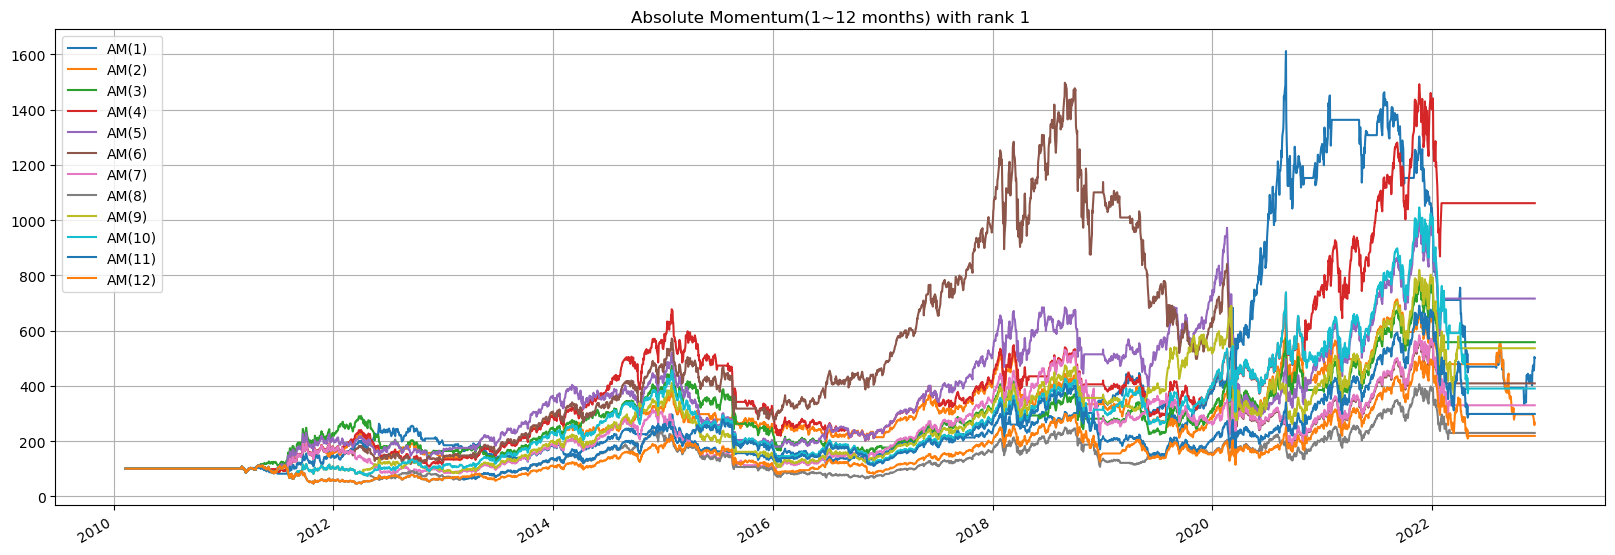

In [12]:
am1_report.plot(figsize=(20,7), grid=True, title='Absolute Momentum(1~12 months) with rank 1')

In [13]:
print(am1_report.prices[start_day:].calc_stats().display())

Stat                 AM(1)       AM(2)       AM(3)       AM(4)       AM(5)       AM(6)       AM(7)       AM(8)       AM(9)       AM(10)      AM(11)      AM(12)
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10
End                  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         401.29%     166.84%     458.03%     961.31%     615.91%     308.90%     229.57%     129.51%     436.13%     290.18%     198.17%     118.73%
Daily Sharpe         0.53  

In [14]:
# 절대모멘텀 상위 2종목 (1~12개월 비교)
absolutemomentum = {}
for i in range(0, 12):
    absolutemomentum[i] = AbsoluteMomentum_BT(assets[tickers], 2, i+1, start_day, False, lag, name='AM({})'.format(str(i+1)))
    
am2_report = bt.run(*absolutemomentum.values())

<AxesSubplot:title={'center':'Absolute Momentum (1~12 month) with rank 2'}>

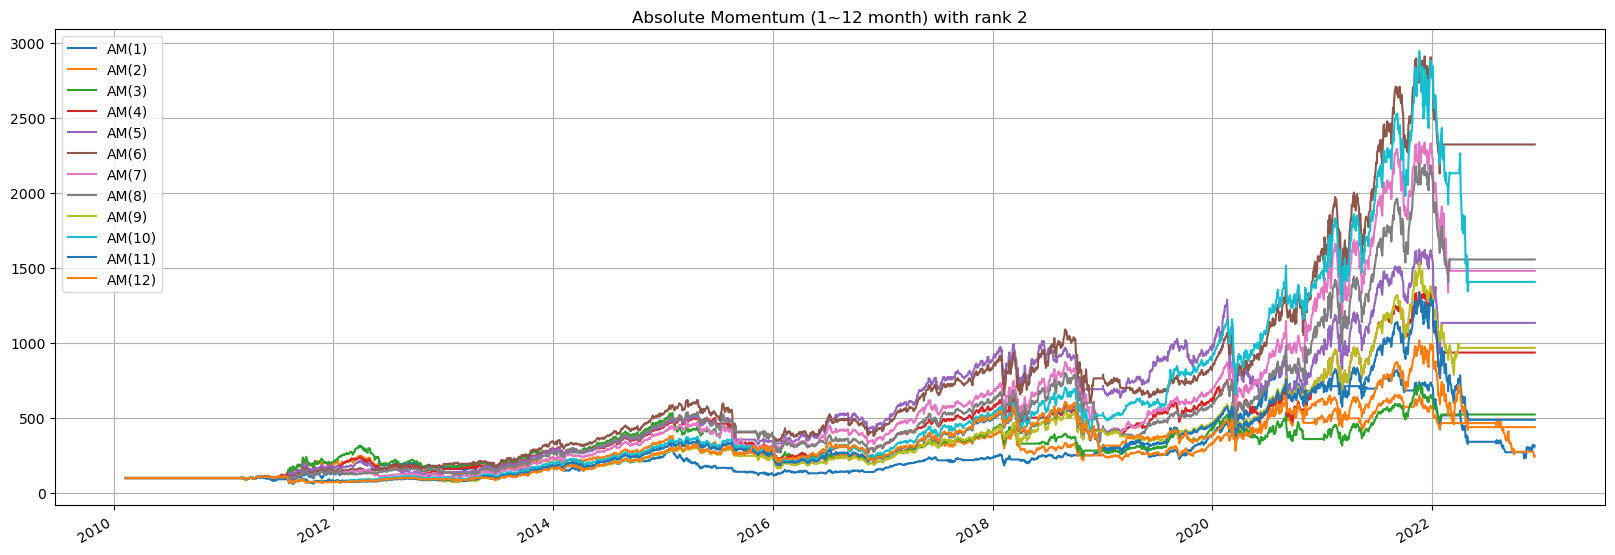

In [15]:
am2_report.plot(figsize=(20,7), grid=True, title='Absolute Momentum (1~12 month) with rank 2')

In [16]:
print(am2_report.prices[start_day:].calc_stats().display())

Stat                 AM(1)       AM(2)       AM(3)       AM(4)       AM(5)       AM(6)       AM(7)       AM(8)       AM(9)       AM(10)      AM(11)      AM(12)
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10
End                  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         216.22%     147.46%     423.27%     835.98%     1033.71%    2222.80%    1380.74%    1456.28%    867.39%     1307.03%    387.87%     339.21%
Daily Sharpe         0.44  

In [17]:
# 듀얼모멘텀 백테스트
def DualMomentum_BT(assets, rank, months, start_day, run_on_end_of_period=False, lag=1, name='Dual Momentum'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           SelectDualMomentum(rank=rank, lookback=pd.DateOffset(months=months), lag=pd.DateOffset(days=lag)),
                           bt.algos.WeighEqually(),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [18]:
# 듀얼모멘텀 상위 1종목 (1~12개월 비교)
dualmomentums = {}
for i in range(0, 12):
    dualmomentums[i] = DualMomentum_BT(assets, 1, i+1, start_day, False, lag, name='ODM({})'.format(str(i+1)))

dm1_report = bt.run(*dualmomentums.values())

<AxesSubplot:title={'center':'Dual Momentum (1~12 months) with rank 1'}>

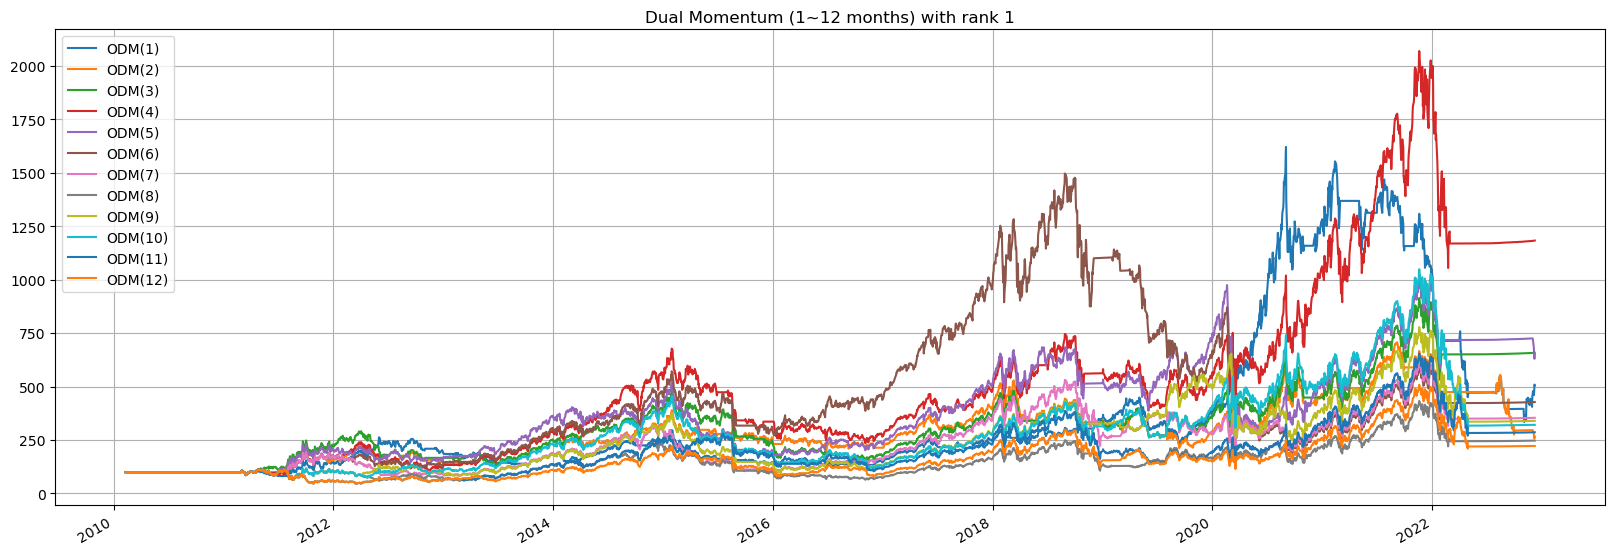

In [19]:
dm1_report.plot(figsize=(20,7), grid=True, title='Dual Momentum (1~12 months) with rank 1')

In [20]:
print(dm1_report.prices[start_day:].calc_stats().display())

Stat                 ODM(1)      ODM(2)      ODM(3)      ODM(4)      ODM(5)      ODM(6)      ODM(7)      ODM(8)      ODM(9)      ODM(10)     ODM(11)     ODM(12)
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10
End                  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         405.72%     166.27%     557.96%     1082.42%    552.06%     327.65%     253.91%     147.25%     239.66%     220.88%     186.17%     122.25%
Daily Sharpe         0.53 

In [21]:
# 듀얼모멘텀 상위 2종목 (1~12개월 비교)
dualmomentums = {}
for i in range(0, 12):
    dualmomentums[i] = DualMomentum_BT(assets, 2, i+1, start_day, False, lag, name='ODM({})'.format(str(i+1)))

dm2_report = bt.run(*dualmomentums.values())

<AxesSubplot:title={'center':'Dual Momentum (1~12 months) with rank 2'}>

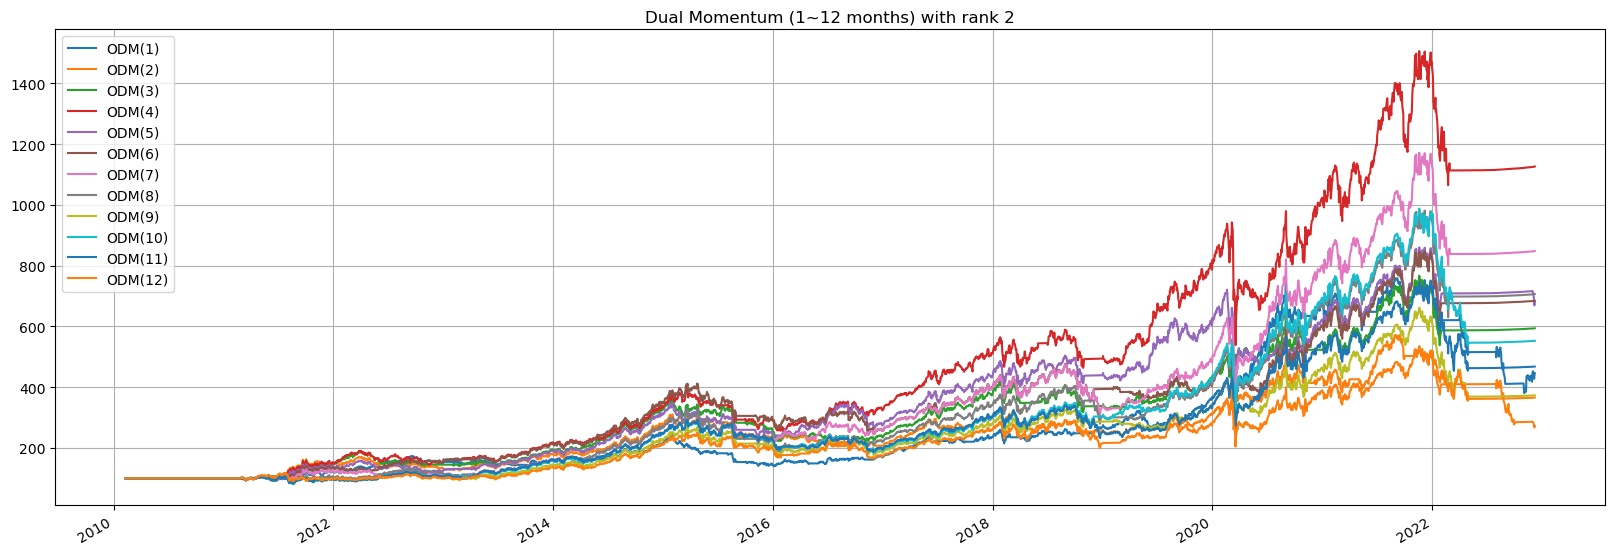

In [22]:
dm2_report.plot(figsize=(20,7), grid=True, title='Dual Momentum (1~12 months) with rank 2')

In [23]:
print(dm2_report.prices[start_day:].calc_stats().display())

Stat                 ODM(1)      ODM(2)      ODM(3)      ODM(4)      ODM(5)      ODM(6)      ODM(7)      ODM(8)      ODM(9)      ODM(10)     ODM(11)     ODM(12)
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10
End                  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         345.86%     171.89%     493.96%     1026.54%    580.50%     584.43%     748.19%     606.43%     273.07%     452.63%     367.88%     265.63%
Daily Sharpe         0.65 

In [4]:
# 평균모멘텀 스코어 백테스트
def AverageMomentum_BT(assets, months, start_day, run_on_end_of_period=False, lag=1, cash_weight=0, name='Average Momentum'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           bt.algos.SelectAll(),
                           WeighAMS(lookback=months, lag=lag, cash_weight=cash_weight, returns=None, ylookback=0),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [4]:
assets_cash = assets[tickers].copy()
# 1년을 252 영업일로 가정
#assets_cash['cash'] = pow(1.03, 1/252)
#assets_cash['cash'] = assets_cash['cash'].shift(1, fill_value=1.0)
#assets_cash['cash'] = assets_cash['cash'].cumprod()
assets_cash['cash'] = assets[dualtickers[1]]
print(assets_cash)

                 TQQQ        TMF       cash
Date                                       
2010-02-11   0.431471   6.695424  86.560005
2010-02-12   0.433238   6.771190  86.560005
2010-02-16   0.450019   6.831800  86.560005
2010-02-17   0.457656   6.613165  86.503410
2010-02-18   0.466332   6.500601  86.541138
...               ...        ...        ...
2022-12-02  23.410000   9.610000  91.440002
2022-12-05  22.230000   9.230000  91.449997
2022-12-06  20.820000   9.590000  91.480003
2022-12-07  20.570000  10.230000  91.480003
2022-12-08  21.299999  10.160000  91.540001

[3230 rows x 3 columns]


In [5]:
# 평균모멘텀 
averagemomentums = {}
cash_weights = [0, 0.3, 0.6]
for i in range(0, len(cash_weights)):
    averagemomentums[i] = AverageMomentum_BT(assets_cash, 12, start_day, False, lag, cash_weights[i], 'AMS_CASH({})'.format(cash_weights[i]))
    
avg_report = bt.run(*averagemomentums.values())

                 TQQQ        TMF       cash
Date                                       
2010-02-11   0.431471   6.695425  86.560013
2010-02-12   0.433238   6.771189  86.560013
2010-02-16   0.450019   6.831801  86.560013
2010-02-17   0.457656   6.613164  86.503387
2010-02-18   0.466332   6.500601  86.541168
...               ...        ...        ...
2022-12-02  23.410000   9.610000  91.440002
2022-12-05  22.230000   9.230000  91.449997
2022-12-06  20.820000   9.590000  91.480003
2022-12-07  20.570000  10.230000  91.480003
2022-12-08  21.299999  10.160000  91.540001

[3230 rows x 3 columns]


<AxesSubplot:title={'center':'Average Momentum'}>

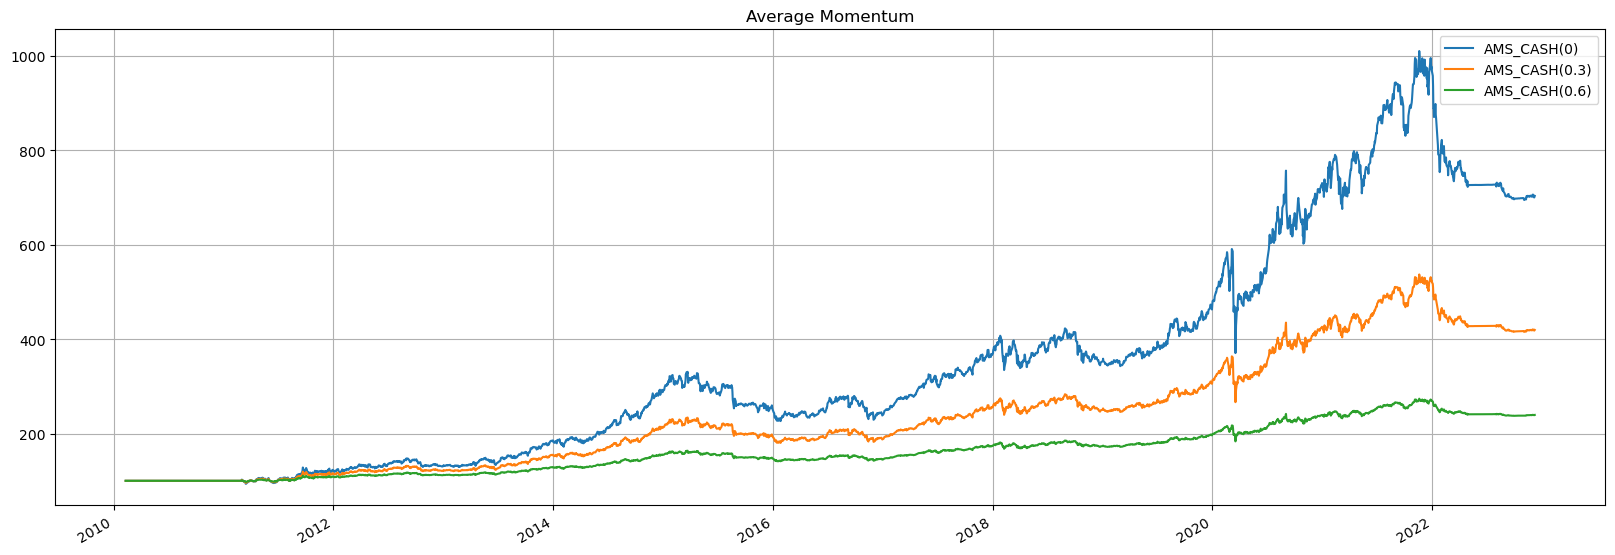

In [6]:
avg_report.plot(figsize=(20,7), grid=True, title='Average Momentum')

In [7]:
avg_report.prices[start_day:].calc_stats().display()

Stat                 AMS_CASH(0)    AMS_CASH(0.3)    AMS_CASH(0.6)
-------------------  -------------  ---------------  ---------------
Start                2011-02-10     2011-02-10       2011-02-10
End                  2022-12-08     2022-12-08       2022-12-08
Risk-free rate       0.00%          0.00%            0.00%

Total Return         603.36%        319.54%          139.48%
Daily Sharpe         0.84           0.85             0.87
Daily Sortino        1.30           1.31             1.35
CAGR                 17.94%         12.89%           7.66%
Max Drawdown         -37.30%        -26.69%          -15.57%
Calmar Ratio         0.48           0.48             0.49

MTD                  -0.29%         -0.16%           -0.03%
3m                   -0.14%         0.13%            0.40%
6m                   -3.19%         -1.90%           -0.61%
YTD                  -27.31%        -19.44%          -11.00%
1Y                   -28.28%        -20.20%          -11.49%
3Y (ann.)          

<AxesSubplot:>

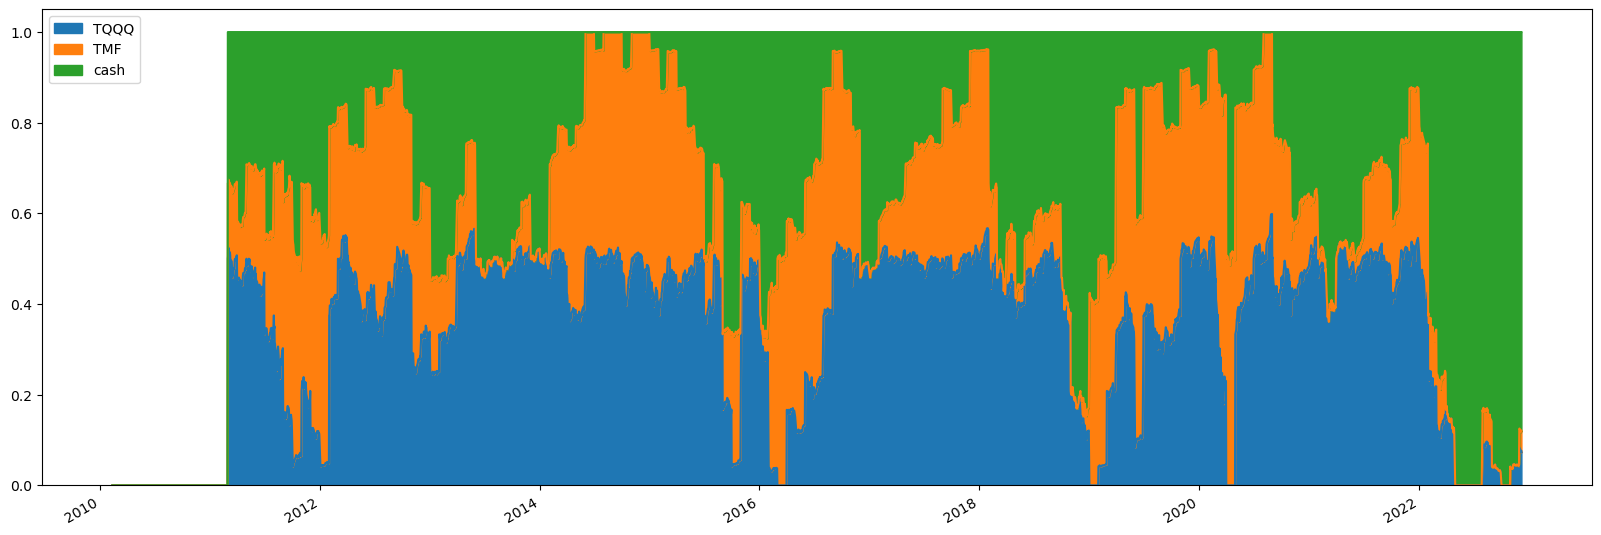

In [6]:
avg_report.get_security_weights().plot.area(figsize=(20,7))

In [9]:
# 수익률곡선+평균모멘텀 스코어 백테스트
def YieldCurveMomentum_BT(assets, months, start_day, run_on_end_of_period=False, lag=1, returns=None, ymonths=6, name='Yield Curve AMS'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           bt.algos.SelectAll(),
                           WeighAMS(lookback=months, lag=lag, cash_weight=0, returns=returns, ylookback=ymonths),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [10]:
yieldcurve = avg_report.prices['AMS_CASH(0)'].rebase(1).to_frame().copy()
yams = {}
for i in range(0,12):
    yams[i] = YieldCurveMomentum_BT(assets_cash, 12, start_day, False, lag, yieldcurve, i+1, '{}M_Y AMS'.format(str(i+1)))

yams_report = bt.run(*yams.values())

<AxesSubplot:title={'center':'Yield Curve Momentum'}>

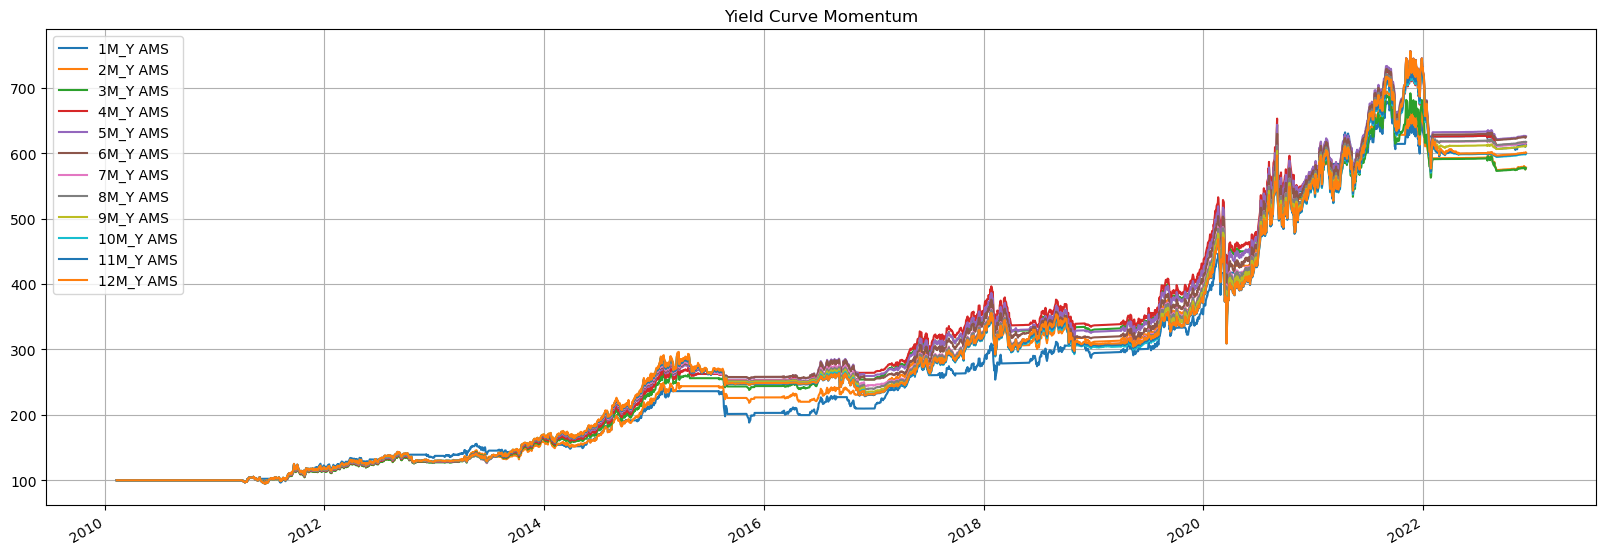

In [11]:
yams_report.plot(figsize=(20,7), grid=True, title='Yield Curve Momentum')

In [32]:
yams_report.prices[start_day:].calc_stats().display()

Stat                 1M_Y AMS    2M_Y AMS    3M_Y AMS    4M_Y AMS    5M_Y AMS    6M_Y AMS    7M_Y AMS    8M_Y AMS    9M_Y AMS    10M_Y AMS    11M_Y AMS    12M_Y AMS
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  -----------  -----------  -----------
Start                2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10  2011-02-10   2011-02-10   2011-02-10
End                  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08  2022-12-08   2022-12-08   2022-12-08
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%        0.00%        0.00%

Total Return         512.50%     478.01%     476.93%     516.30%     525.97%     524.65%     515.30%     517.18%     510.97%     498.69%      499.93%      500.99%
Daily Sharp

In [4]:
# 변동성역가중 백테스트(일간데이터)
def WeighInvVol_BT(assets, months, start_day, run_on_end_of_period=False, lag=1, name='Inverse Volatility'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighInvVol(lookback=pd.DateOffset(months=months), lag=pd.DateOffset(days=lag)),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [5]:
# 변동성역가중 백테스트(월간 기준)
def WeighInvVol_BT2(assets, months, start_day, run_on_end_of_period=False, lag=1, returns=None, ymonths=0, name='Inverse Volatility'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           bt.algos.SelectAll(),
                           WeighInvVolByMonth(lookback=months, lag=lag, returns=returns, ylookback=ymonths),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [6]:
# 변동성 역가중(일간, 월간)
invVol_daily = WeighInvVol_BT(assets[tickers], 12, start_day, True, lag, name='Inv Volatility(daily)')
invVol_monthly = WeighInvVol_BT2(assets[tickers], 12, start_day, False, lag, None, 0, name='Inv Volatility(monthly)')
invVol_report = bt.run(invVol_daily, invVol_monthly)

<AxesSubplot:title={'center':'Inverse Volatility'}>

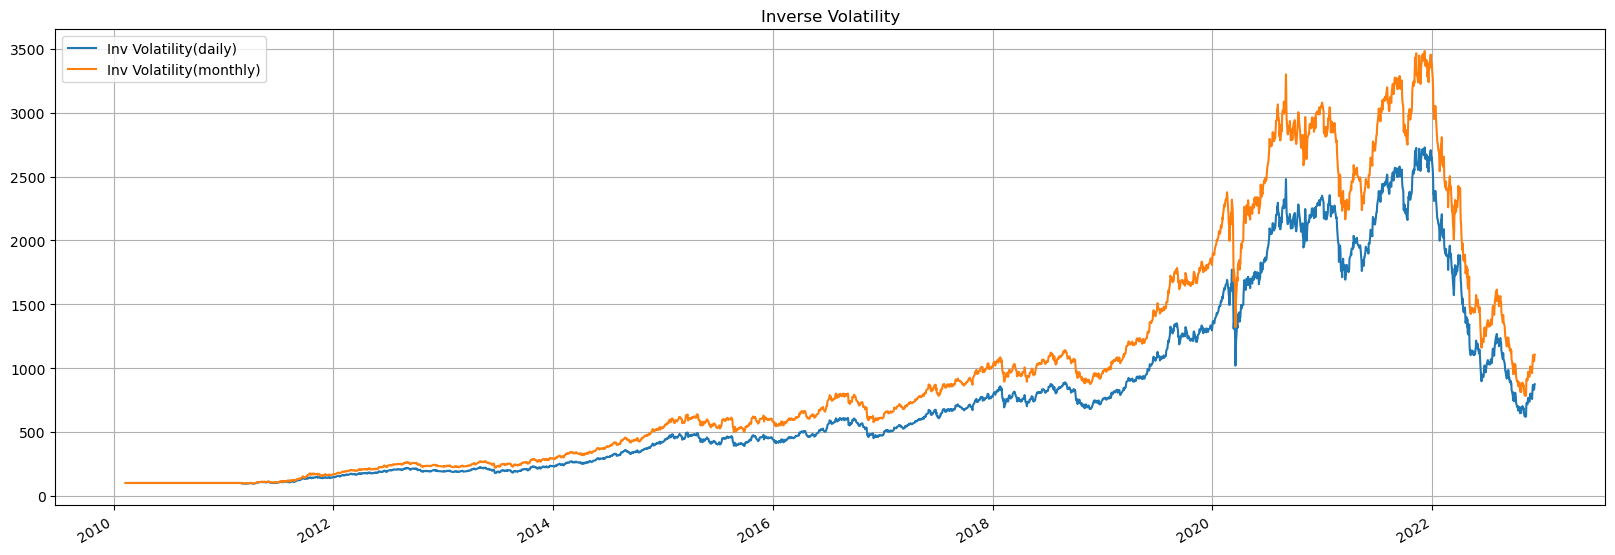

In [7]:
invVol_report.plot(figsize=(20,7), grid=True, title='Inverse Volatility')

In [8]:
#invVol_report.prices[start_day:].calc_stats().display()
invVol_report.set_date_range(start_day)
invVol_report.display()

Stat                 Inv Volatility(daily)    Inv Volatility(monthly)
-------------------  -----------------------  -------------------------
Start                2011-02-10               2011-02-10
End                  2022-12-08               2022-12-08
Risk-free rate       0.00%                    0.00%

Total Return         773.28%                  1005.60%
Daily Sharpe         0.75                     0.81
Daily Sortino        1.19                     1.29
CAGR                 20.11%                   22.53%
Max Drawdown         -77.29%                  -77.56%
Calmar Ratio         0.26                     0.29

MTD                  8.88%                    9.13%
3m                   -8.44%                   -8.56%
6m                   -21.98%                  -23.47%
YTD                  -66.81%                  -67.08%
1Y                   -67.24%                  -67.52%
3Y (ann.)            -12.07%                  -14.49%
5Y (ann.)            2.76%                    2.28%
10

In [6]:
# 변동성 역가중(월간) 1~12개월 모멘텀
invVol_months = {}
for i in range(0, 12):
    invVol_months[i] = WeighInvVol_BT2(assets[tickers], i+1, start_day, False, lag, name='InvVol_{}M'.format(str(i+1)))

invVol_months_report = bt.run(*invVol_months.values())

<AxesSubplot:title={'center':'Inverse Volatility (1~12) months'}>

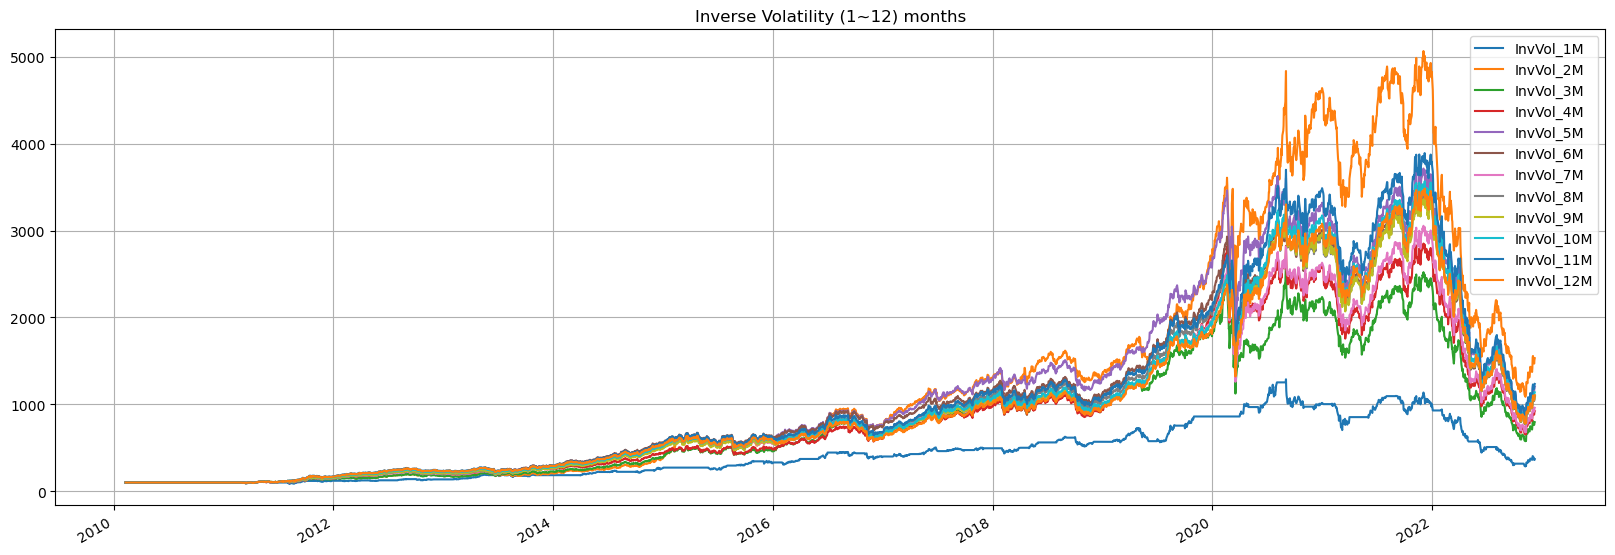

In [7]:
invVol_months_report.plot(figsize=(20,7), grid=True, title='Inverse Volatility (1~12) months')

In [8]:
invVol_months_report.set_date_range(start_day)
invVol_months_report.display()

Stat                 InvVol_1M    InvVol_2M    InvVol_3M    InvVol_4M    InvVol_5M    InvVol_6M    InvVol_7M    InvVol_8M    InvVol_9M    InvVol_10M    InvVol_11M    InvVol_12M
-------------------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  -----------  ------------  ------------  ------------
Start                2011-02-10   2011-02-10   2011-02-10   2011-02-10   2011-02-10   2011-02-10   2011-02-10   2011-02-10   2011-02-10   2011-02-10    2011-02-10    2011-02-10
End                  2022-12-08   2022-12-08   2022-12-08   2022-12-08   2022-12-08   2022-12-08   2022-12-08   2022-12-08   2022-12-08   2022-12-08    2022-12-08    2022-12-08
Risk-free rate       0.00%        0.00%        0.00%        0.00%        0.00%        0.00%        0.00%        0.00%        0.00%        0.00%         0.00%         0.00%

Total Return         270.44%      1430.98%     694.72%      821.76%      1104.19%     988.57%      860.28%      997.7

In [9]:
# 수익률곡선+변동성역가중 백테스트
def yWeighInvVol_BT2(assets, months, start_day, run_on_end_of_period=False, lag=1, returns=None, ymonths=6, name='Yield Curve AMS'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           bt.algos.PrintDate(),
                           bt.algos.SelectAll(),
                           WeighInvVolByMonth(lookback=months, lag=lag, returns=returns, ylookback=ymonths),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [16]:
yieldcurve = invVol_months_report.prices['InvVol_2M'].rebase(1).to_frame().copy()
print(yieldcurve)
print(assets_cash)
print(start_day)

            InvVol_2M
2011-02-10   1.000000
2011-02-11   1.000000
2011-02-14   1.000000
2011-02-15   1.000000
2011-02-16   1.000000
...               ...
2022-12-02  15.567912
2022-12-05  14.867612
2022-12-06  14.689029
2022-12-07  15.123229
2022-12-08  15.309789

[2978 rows x 1 columns]
                 TQQQ        TMF       cash
Date                                       
2010-02-11   0.431471   6.695424  86.560005
2010-02-12   0.433238   6.771190  86.560005
2010-02-16   0.450019   6.831800  86.560005
2010-02-17   0.457656   6.613165  86.503410
2010-02-18   0.466332   6.500601  86.541138
...               ...        ...        ...
2022-12-02  23.410000   9.610000  91.440002
2022-12-05  22.230000   9.230000  91.449997
2022-12-06  20.820000   9.590000  91.480003
2022-12-07  20.570000  10.230000  91.480003
2022-12-08  21.299999  10.160000  91.540001

[3230 rows x 3 columns]
2011-02-10 00:00:00


In [10]:
yieldcurve = invVol_months_report.prices['InvVol_2M'].rebase(1).to_frame().copy()
#yInvVols = {}
#for i in range(0,12):
#    yInvVols[i] = yWeighInvVol_BT2(assets_cash, 12, start_day, False, lag, yieldcurve, i+1, '{}M_Y InvVol'.format(str(i+1)))

yInvVols = yWeighInvVol_BT2(assets_cash, 12, start_day, False, lag, yieldcurve, 1, '{}M_Y InvVol')
yInvVol_report = bt.run(yInvVols)
#yInvVol_report = bt.run(*yInvVols.values())

2011-03-01 00:00:00
1start=2011-01-28 00:00:00, end=2011-02-28 00:00:00


OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 1677-09-21 00:00:00

In [10]:
yInvVol_report.set_date_range(start_day)
yInvVol_report.display()

Stat                 {}M_Y InvVol
-------------------  --------------
Start                2011-02-10
End                  2022-12-08
Risk-free rate       0.00%

Total Return         251.59%
Daily Sharpe         1.10
Daily Sortino        1.72
CAGR                 11.22%
Max Drawdown         -15.57%
Calmar Ratio         0.72

MTD                  1.19%
3m                   1.81%
6m                   -9.04%
YTD                  -10.22%
1Y                   -10.81%
3Y (ann.)            9.08%
5Y (ann.)            9.99%
10Y (ann.)           10.20%
Since Incep. (ann.)  11.22%

Daily Sharpe         1.10
Daily Sortino        1.72
Daily Mean (ann.)    11.16%
Daily Vol (ann.)     10.14%
Daily Skew           -0.26
Daily Kurt           4.93
Best Day             4.46%
Worst Day            -3.70%

Monthly Sharpe       1.07
Monthly Sortino      2.35
Monthly Mean (ann.)  11.21%
Monthly Vol (ann.)   10.51%
Monthly Skew         0.71
Monthly Kurt         3.60
Best Month           14.65%
Worst Month      

In [41]:
# 가속듀얼모멘텀 백테스트
def WeighADM_BT(assets, rank, start_day, run_on_end_of_period=False, lag=1, name='Accelerating DM'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           bt.algos.SelectAll(),
                           WeighADM(rank=rank, lag=pd.DateOffset(days=lag)),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [42]:
# 가속 듀얼모멘텀 1~2종목
assets_adm = assets[tickers].copy()
assets_adm[dualtickers[1]] = assets[dualtickers[1]]
          
adms = {}
for i in range(0,2):
    adms[i] = WeighADM_BT(assets_adm, i+1, start_day, False, lag, name='ADM_{}R'.format(str(i+1)))
adm_report = bt.run(*adms.values())

<AxesSubplot:title={'center':'ADM (1~2) ranks'}>

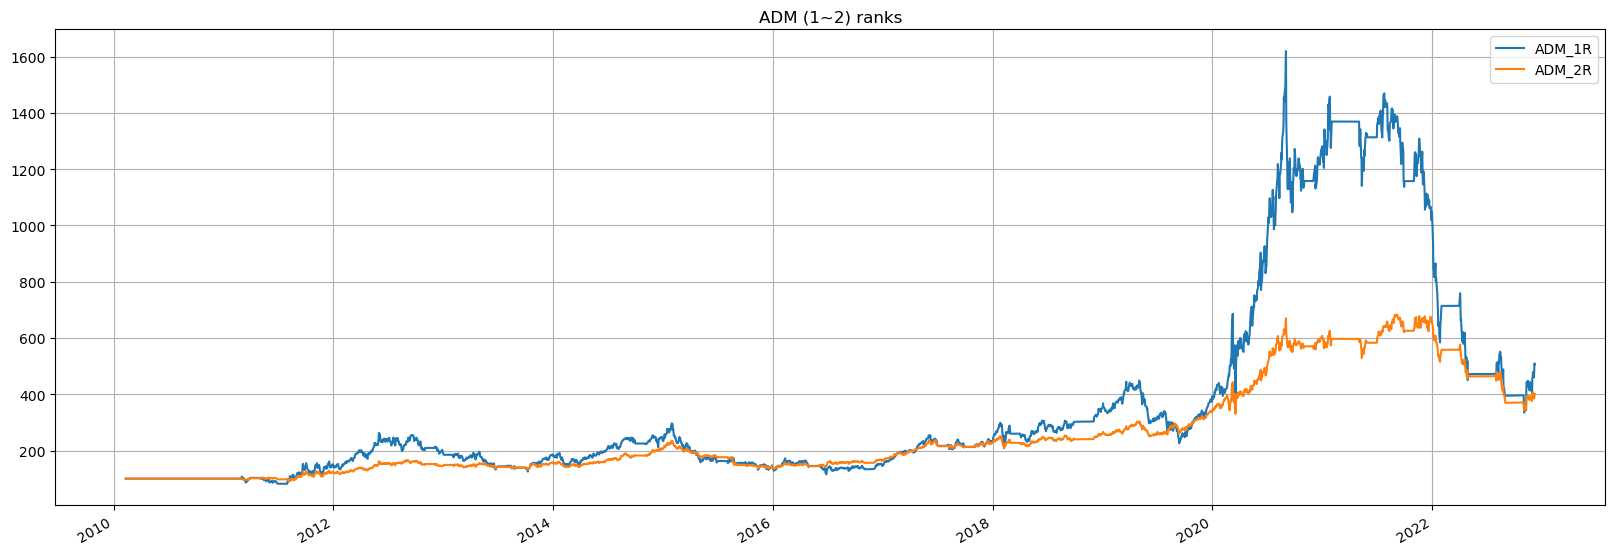

In [43]:
adm_report.plot(figsize=(20,7), grid=True, title='ADM (1~2) ranks')

In [44]:
adm_report.set_date_range(start_day)
adm_report.display()

Stat                 ADM_1R      ADM_2R
-------------------  ----------  ----------
Start                2011-02-10  2011-02-10
End                  2022-12-08  2022-12-08
Risk-free rate       0.00%       0.00%

Total Return         406.23%     301.17%
Daily Sharpe         0.53        0.61
Daily Sortino        0.83        0.96
CAGR                 14.70%      12.47%
Max Drawdown         -79.34%     -49.88%
Calmar Ratio         0.19        0.25

MTD                  10.09%      0.00%
3m                   28.16%      8.52%
6m                   7.28%       -13.50%
YTD                  -51.73%     -38.81%
1Y                   -52.07%     -39.67%
3Y (ann.)            15.18%      8.23%
5Y (ann.)            17.87%      12.46%
10Y (ann.)           9.17%       10.33%
Since Incep. (ann.)  14.70%      12.47%

Daily Sharpe         0.53        0.61
Daily Sortino        0.83        0.96
Daily Mean (ann.)    24.19%      14.58%
Daily Vol (ann.)     45.60%      23.72%
Daily Skew           -0.16       -